Imports


In [1]:
import os
import cv2 as cv
import numpy as np
from math import pi
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Defines

In [2]:
N1, N2 = 5, 8
h, w = int(60/N1), int(120/N2)

def readDataset():
  dir = 'Dataset'
  genuine = []
  skill = []
  for item in os.listdir(dir):
    img_dir = dir+'/'+item+'/genuine/Images'
    imgs = os.listdir(img_dir)
    genuine += [[]]
    for img in imgs:
      im = cv.imread(img_dir+'/'+img, 0).astype(np.float32)
      im = cv.rotate(im, cv.cv2.ROTATE_90_CLOCKWISE)
      im = cv.resize(im, (120, 60), interpolation = cv.INTER_AREA)
      genuine[len(genuine)-1] += [im]
    img_dir = dir+'/'+item+'/skilled forgery/Images'
    imgs = os.listdir(img_dir)
    skill += [[]]
    for img in imgs:
      im = cv.imread(img_dir+'/'+img, 0).astype(np.float32)
      im = cv.rotate(im, cv.cv2.ROTATE_90_CLOCKWISE)
      im = cv.resize(im, (120, 60), interpolation = cv.INTER_AREA)
      skill[len(skill)-1] += [im]
  return genuine, skill

def normalize(image):
  img = image.copy()
  return (img - np.mean(img))/np.std(img)

def GT(img, kernel):
  out = cv.filter2D(img, -1, kernel/np.sum(kernel))
  return normalize(out).copy()

def Box(img, i, j, h, w):
  return img[i*h:i*h+h, j*w:j*w+w].copy()

def findF(img):
  Fs = []
  for i in range(N1):
    for j in range(N2):
      box = Box(img, i, j, h, w)
      F = 0
      n = 0
      for x_i in range(box.shape[0]):
        for y_j in range(box.shape[1]):
          if(box[x_i][y_j]>0.5):
            n+=1
            F += np.arctan((h-x_i+1)/(y_j+1))/np.pi*180
      if(n!=0):
        F = F / n
      Fs += [F]
  return Fs.copy()

def findF_for_all_kernels(img, kernels):
  Fs = []
  for kernel in kernels:
    out = GT(img, kernel)
    Fs += findF(out)
  return np.array(Fs).copy()

def findF_for_all_data(genuines, skills, kernels):
  Fs = []
  for i in range(len(genuines)):
    Fs += [findF_for_all_kernels(genuines[i], kernels)]
  for i in range(len(skills)):
    Fs += [findF_for_all_kernels(skills[i], kernels)]
  Fs = np.array(Fs)
  Fs = StandardScaler().fit_transform(Fs)
  Fs = PCA(3).fit_transform(Fs)
  return Fs[:len(genuines)], Fs[len(genuines):]

def findMuSigma(Fs, kernels):
  mu = np.sum(Fs, axis=0)/len(Fs)
  Fs_mu = Fs-mu
  sigma = Fs_mu.T@Fs_mu/len(Fs)
  return mu, sigma

def findD(Fs, mu, sigma):
  d = []
  for i in range(len(Fs)):
    d += [np.sqrt(np.array(Fs[i]-mu)@np.linalg.inv(sigma)@np.transpose([Fs[i]-mu]))]
  return np.array(d).T[0]

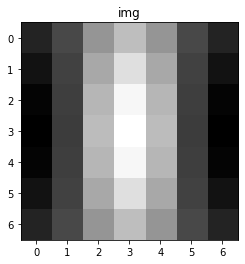

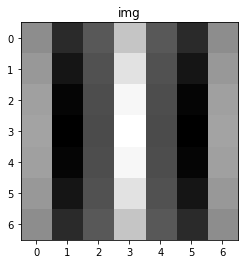

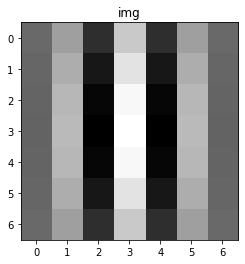

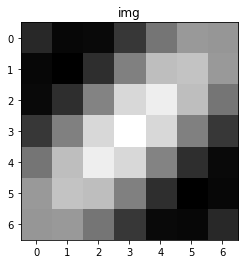

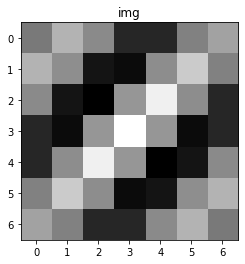

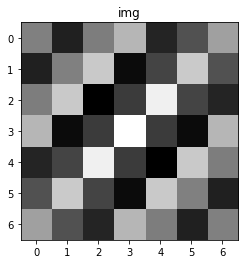

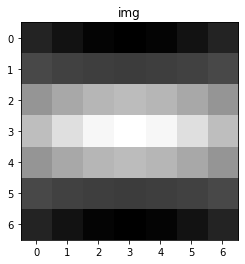

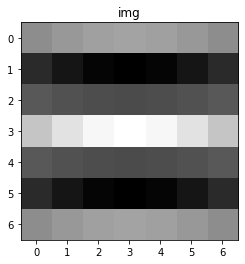

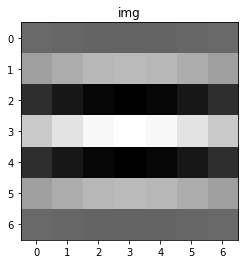

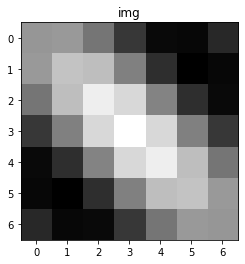

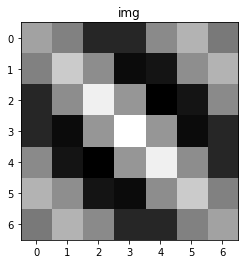

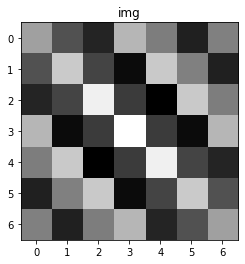

In [3]:
kernels = []
for u in ([0, 2, 4, 6]):
  for v in [1, 2, 3]:
    params = {'ksize': (7,7), 'sigma': 3, 'theta': u*pi/8, 'lambd': 7/v, 'gamma': 1, 'psi' : 0}
    kernels += [cv.getGaborKernel(**params, ktype = cv.CV_32F)]

#     --- show kernels ---
    plt.imshow(kernels[len(kernels)-1], interpolation='nearest', cmap=plt.cm.gray), plt.title("img")
    plt.show()


In [5]:
img = cv.imread('C:\Users\SHREE\Desktop', 0).astype(np.float32)
img = cv.resize(img, (120, 60), interpolation = cv.INTER_AREA)
plt.subplot(121),plt.imshow(img, interpolation='nearest', cmap=plt.cm.gray), plt.title("(a)")
out = GT(img, kernels[0])
plt.subplot(122),plt.imshow(out, interpolation='nearest', cmap=plt.cm.gray), plt.title("(b)")
plt.show()

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (4194524736.py, line 1)

In [6]:
box = Box(out, 0, 0, h, w)
n,x,_ = plt.hist(box.flatten(), bins = np.linspace(0,0.55,50), histtype='step')
plt.close()
bin_centers = 0.5*(x[1:]+x[:-1])
plt.plot(bin_centers,n/(h*w))
plt.xlabel('coefficient')
plt.ylabel('coefficient intensity')
plt.show()

NameError: name 'out' is not defined

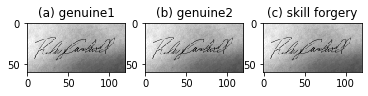

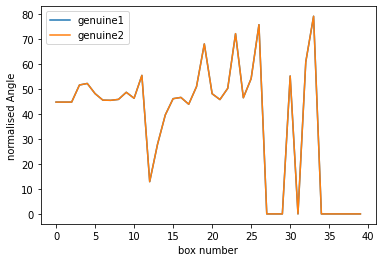

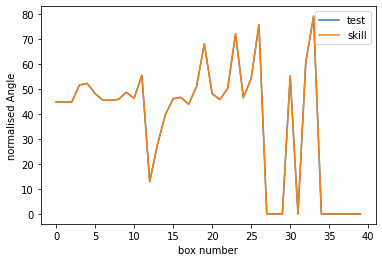

In [13]:
img_a = cv.imread('C:\Users\SHREE\Desktop', 0).astype(np.float32)
img_a = cv.resize(img_a, (120, 60), interpolation = cv.INTER_AREA)
out = GT(img_a, kernels[0])
F_a = findF(out)

img_b = cv.imread('C:\Users\SHREE\Desktop',0).imshow(img_a, interpolation='nearest', cmap=plt.cm.gray), plt.title("(a) genuine1")
plt.subplot(132),plt.imshow(img_b, interpolation='nearest', cmap=plt.cm.gray), plt.title("(b) genuine2")
plt.subplot(133),plt.imshow(img_c, interpolation='nearest', cmap=plt.cm.gray), plt.title("(c) skill forgery")
plt.show()
print()

plt.plot(F_a, label='genuine1')
plt.plot(F_b, label='genuine2')
plt.xlabel('box number')
plt.ylabel('normalised Angle')
plt.legend()
plt.show()

plt.plot(F_a, label='test')
plt.plot(F_c, label='skill')
plt.xlabel('box number')
plt.ylabel('normalised Angle')
plt.legend()
plt.show()
